## SeeFood 

For our final project, we wrote a Convolutional Neural Network (CNN) that recognizes whether a 
food image is or is not a hot dog. Our dataset is from [Kaggle](https://www.kaggle.com/datasets/dansbecker/hot-dog-not-hot-dog?datasetId=8552&sortBy=relevance&searchQuery=CNN),
which is compiled from a dataset of 101 different food items. It is separated into test and train 
folders from the get-go, each with 250 pictures of hot dogs and 250 pictures of other food items.

In [186]:
import pandas as pd
import tensorflow
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
import numpy as np
import os
import cv2
from bokeh.plotting import figure, output_notebook, show
from sklearn.metrics import confusion_matrix
output_notebook()

Loading BokehJS ...

Here are constants needed for the neural network, including number of epochs and batch size.

In [187]:
img_width, img_height = 50, 50
input_shape = (img_width, img_height, 1)
batch_size = 10
num_epochs = 25
num_classes = 2
validation_split = 0.2

#### Image Processing

Here we load the images from the dataset. Based on the data_type and class_name arguments, we can load test and train data, sorted into the hot dog and not hot dog images.

Because the images of are of various sizes, we do some preprocessing to the pictures. We first load
it in grayscale, so that it easier for the neural network to process. Then, we resize the image to
50 x 50 px.

In [188]:
def load_data(data_type, class_name):
    images = []
    labels = []

    for file in os.listdir(f'data/{data_type}/{class_name}'):
        image = cv2.resize(cv2.imread(f'data/{data_type}/{class_name}/{format(file)}', 0), (img_width, img_height))
        # image = cv2.resize(image, (img_width, img_height))
        images.append(image)
        labels.append(0 if class_name == 'not_hot_dog' else 1)

    return (images, labels)

In [189]:
# load and merge training data
X_train_nh, y_train_nh = load_data(data_type="train", class_name="not_hot_dog")
X_train_h, y_train_h = load_data(data_type="train", class_name="hot_dog")
X_train = np.array(X_train_nh + X_train_h)
X_train = X_train.reshape((X_train.shape[0], img_width, img_height, 1))
y_train = np.array(y_train_nh + y_train_h)

# load and merge testing data
X_test_nh, y_test_nh = load_data(data_type="test", class_name="not_hot_dog")
X_test_h, y_test_h = load_data(data_type="test", class_name="hot_dog")
X_test = np.array(X_test_nh + X_test_h)
X_test = X_test.reshape((X_test.shape[0], img_width, img_height, 1))
y_test = np.array(y_test_nh + y_test_h)

A picture of french fries and a hot dog after the preprocessing.

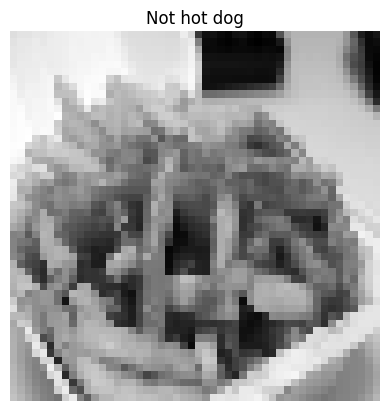

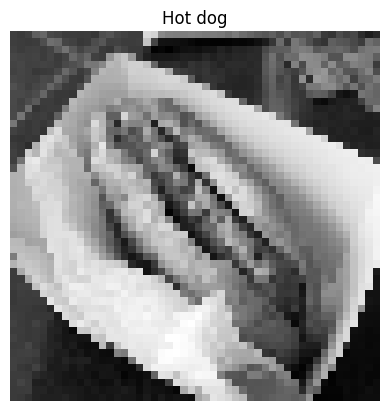

In [190]:
import matplotlib.pyplot as plt

# Display the first image in the training set
plt.imshow(X_train_nh[0], cmap='gray')
plt.title("Not hot dog")
plt.axis("off")
plt.show()

plt.imshow(X_train_h[0], cmap='gray')
plt.axis("off")
plt.title("Hot dog")
plt.show()

#### Neural Network

Our neural network is a CNN with multiple layers. The first three layers are convolutional layers: (1) input layer with four filters, (2) secondary layer with 8 filters, (3) third layer with 12 filters. The next layer flattens the image, and the final dense layers gives us our output: whether or not the image is a hot dog.

In [191]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(Conv2D(8, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(12, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
# model.add(Dense(128, activation="sigmoid"))
model.add(Dense(num_classes, activation="softmax"))

In [192]:
model.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [193]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    validation_split=validation_split)

Epoch 1/25
40/40 [==============================] - 1s 19ms/step - loss: 7.3575 - accuracy: 0.5402 - val_loss: 0.6005 - val_accuracy: 0.7200
Epoch 2/25
40/40 [==============================] - 0s 11ms/step - loss: 0.4340 - accuracy: 0.8216 - val_loss: 1.2619 - val_accuracy: 0.3700
Epoch 3/25
40/40 [==============================] - 0s 10ms/step - loss: 0.1032 - accuracy: 0.9950 - val_loss: 1.3561 - val_accuracy: 0.3400
Epoch 4/25
40/40 [==============================] - 0s 10ms/step - loss: 0.0393 - accuracy: 1.0000 - val_loss: 2.0595 - val_accuracy: 0.1900
Epoch 5/25
40/40 [==============================] - 0s 10ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.9070 - val_accuracy: 0.2900
Epoch 6/25
40/40 [==============================] - 0s 10ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 2.1313 - val_accuracy: 0.2700
Epoch 7/25
40/40 [==============================] - 0s 10ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 2.5587 - val_accuracy: 0.2000
Epoch 8/25
40

After running the model for 25 epochs, we can see that we have a pretty mediocre accuracy of around 50%.

In [ ]:
score = model.evaluate(X_test, y_test)
# print(f'test loss: {score[0]}, test accuracy: {score[1]}')

16/16 [==============================] - 0s 17ms/step - loss: 5.6759 - accuracy: 0.5240


To evaluate our model, we show the confusion matrix and some metrics.

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)
cm

16/16 [==============================] - 0s 11ms/step


array([[218,  32],
       [206,  44]])

In [ ]:
tn, fp, fn, tp = cm.ravel()
pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1"],
    "Value": [(tp+tn)/(tp+fp+fn+tn), tp/(tp+fp), tp/(tp+fn), (2*tp/(tp+fp))*(tp/(tp+fn)) / ((tp/(tp+fp))+(tp/(tp+fn)))]
})

,Metric,Value
0,Accuracy,0.524000
1,Precision,0.578947
2,Recall,0.176000
3,F1,0.269939


Here is a plot showing the training and validation loss along with their accuracy. As you can see, the validation loss and accuracy are not very good for this model. They don't converge with the rest of the training data. We believe this is because the network overfits to the training data.

In [ ]:
# extract loss values from the training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))

# create plot
p = figure(title="Training and Validation Loss", x_axis_label="Epoch", y_axis_label="Loss")
p.line(epochs, train_loss, legend_label="Train Loss", line_color="blue")
p.line(epochs, valid_loss, legend_label="Validation Loss", line_color="red")

# show it
show(p)

train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
epochs = list(range(1, len(train_accuracy) + 1))

p = figure(title="Training and Validation Accuracy", x_axis_label="Epoch", y_axis_label="Accuracy")
p.line(epochs, train_accuracy, legend_label="Train Accuracy", line_color="blue")
p.line(epochs, valid_accuracy, legend_label="Validation Accuracy", line_color="red")

show(p)